# Figure 2 (MIP curated panels)

The code below has been used to create Figure 2b, 2d and 2f (MIP curated) in [the main paper](https://www.biorxiv.org/content/10.1101/2022.03.18.484903v2) as well as Figures S65 and S68 in the [supplement](https://www.biorxiv.org/content/10.1101/2022.03.18.484903v2.supplementary-material). By default, all plots in this notebooks were created using the curated part (3052 MIP indices), but one can easily change it by replacing one line of code (see section `Plots`) and generate plots using the whole Random5000 dataset (5000 MIP indices).

Contact: pawel.szczerbiak@uj.edu.pl or p.szczerbiak@gmail.com

Before running other cells, run the commands below in the terminal and activate the  `<env_name>` kernel in this notebook:

`conda create -n <env_name> numpy scikit-learn seaborn ipykernel`  
`conda activate <env_name>`  
`ipython kernel install --user --name=<env_name>`

Alternatively, one can use `virtualenv` instead of `conda` package manager.

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics.pairwise import pairwise_distances

## Global paths

**NOTE:** change the paths below appropriately.  
The first one should point to the `intermediate_data` folder downloded from the [Zenodo](https://zenodo.org/record/6477242#.Yoyp1PNBxqs) website.

In [2]:
MAIN_DIR = Path('/path/to/intermediate_data/')
OUT_DIR = Path('./')  # current notebook directory

## Data generation

### All-against-all comparisons

See `pairwise_comparisons/tmalign/`

#### Notes

- all quantities were computed using `TMalign` (see the paper for details)
- computations were performed in a pairwise manner without duplicates (upper triangular matrix)

#### Columns description
- `MIP name 1` - ID of the first compared MIP  
- `MIP name 2` - ID of the second compared MIP  
- `MIP length 1` - length of the first compared MIP [aa]  
- `MIP length 2` - length of the second compared MIP [aa] 
- `Alignment length` - number of aligned residues [aa]
- `Sequence identity`
- `RMSD` - root-mean-square deviation
- `TM-score 1`- TM-score normalized by the first MIP length
- `TM-score 2`- TM-score normalized by the second MIP length
- `TM-score mean` - $\rm (TM_{score\;1} + TM_{score\;2})\;/\;2$ 
- `TM-score max` - $\rm max (TM_{score\;1}, TM_{score\;2})$ 

### DeepFRI predictions

See `pairwise_comparisons/deepfri/`

DeepFRI predictions were generated in the same way as the MIP curated predictions (see the paper for details).

## Load data

### All-against-all comparisons

In [3]:
dmpfold_m2m  =  pickle.load(open(MAIN_DIR / 'pairwise_comparisons' / 'tmalign' / 'random5000_dmpfold_m2m_full.pkl', 'rb'))
rosetta_m2m  =  pickle.load(open(MAIN_DIR / 'pairwise_comparisons' / 'tmalign' / 'random5000_rosetta_m2m_full.pkl', 'rb'))

### DeepFRI predictions

In [4]:
dmpfold_deepfri, rosetta_deepfri = {}, {}
keys = ["BP", "CC", "MF", "EC"]
for key in keys:
    dmpfold_deepfri[key] = pd.read_csv(MAIN_DIR / 'pairwise_comparisons' / 'deepfri' / f'random5000_dmpfold_{key}.csv', index_col=0)
    rosetta_deepfri[key] = pd.read_csv(MAIN_DIR / 'pairwise_comparisons' / 'deepfri' / f'random5000_rosetta_{key}.csv', index_col=0)

#### Check if MIP IDs agree among all groups and are sorted in random5000 order

In [5]:
for key_1 in keys:
    for key_2 in keys:
        assert dmpfold_deepfri[key_1].index.equals(dmpfold_deepfri[key_2].index)
        assert rosetta_deepfri[key_1].index.equals(rosetta_deepfri[key_2].index)       
        assert dmpfold_deepfri[key_1].index.equals(rosetta_deepfri[key_2].index)   

In [6]:
random5000_ind = pd.read_csv(MAIN_DIR / 'pairwise_comparisons' / 'indices' / 'random5000.txt', header=None).values[:,0]
assert (random5000_ind == dmpfold_deepfri['BP'].index).all()

#### Create prediction arrays

In [7]:
dmpfold_deepfri_arr = np.hstack([dmpfold_deepfri[key].values for key in keys])
rosetta_deepfri_arr = np.hstack([rosetta_deepfri[key].values for key in keys])

## Calculate function similarities

### Sort DeepFRI predictions

In [8]:
# DeepFRI prediction indices (any key may be chosen)
deepfri_ind = dmpfold_deepfri['EC'].index
# Sort DeepFRI prediction indices using alphabetical order
# i.e. the same one as in the m2m matrices above
deepfri_order_dict = dict(zip(deepfri_ind, range(len(deepfri_ind))))
alphabetical_order = [deepfri_order_dict[el] for el in sorted(deepfri_ind)]

In [9]:
def calc_m2m_attr(mat, metric='cosine', out_order=alphabetical_order):
    """
    'mat' is of shape: nxm
        'n' - number of samples
        'm' - number of features
    'out_order' is the order for output indices
        note: 'mat' is sorted in Random5000 order
        but 'm2m' matrices are sorted in alphabetical order
    """
    # Compute distance matrix
    result = pairwise_distances(mat, metric=metric)
    # Discard lower triangle and main diagonal
    result[np.tril_indices(len(result))] = np.nan
    # Sort the output triangular matrix
    result = result[out_order]
    # Remove nans
    result = result[~np.isnan(result)]
    return result

### Add cosine similarity between DeepFRI vectors to the pairwise dataframes

In [10]:
thr = 0.1  # used for denoising
rosetta_m2m["DeepFRI GCN cossim denoised"] = 1 - calc_m2m_attr(np.where(rosetta_deepfri_arr>=thr, 
                                               rosetta_deepfri_arr, 0))
dmpfold_m2m["DeepFRI GCN cossim denoised"] = 1 - calc_m2m_attr(np.where(dmpfold_deepfri_arr>=thr, 
                                               dmpfold_deepfri_arr, 0))

### Sanity check

Check results manually

In [11]:
ind1 = 1255
ind2 = 4955
# Rosetta
t1 = np.where(rosetta_deepfri_arr[ind1]>=thr, rosetta_deepfri_arr[ind1], 0)
t2 = np.where(rosetta_deepfri_arr[ind2]>=thr, rosetta_deepfri_arr[ind2], 0)
manual = 1 - pairwise_distances(np.array([t1, t2]), metric='cosine')[0, 1]
assert manual == rosetta_m2m[(dmpfold_m2m['MIP name 1'] == random5000_ind[ind1]) & \
            (rosetta_m2m['MIP name 2'] == random5000_ind[ind2])]['DeepFRI GCN cossim denoised'].values[0]
# DMPfold
t1 = np.where(dmpfold_deepfri_arr[ind1]>=thr, dmpfold_deepfri_arr[ind1], 0)
t2 = np.where(dmpfold_deepfri_arr[ind2]>=thr, dmpfold_deepfri_arr[ind2], 0)
manual = 1 - pairwise_distances(np.array([t1, t2]), metric='cosine')[0, 1]
assert manual == dmpfold_m2m[(dmpfold_m2m['MIP name 1'] == random5000_ind[ind1]) & \
            (dmpfold_m2m['MIP name 2'] == random5000_ind[ind2])]['DeepFRI GCN cossim denoised'].values[0]

### Consider only MIP curated IDs

In [12]:
random5000_curated_ind = pd.read_csv(MAIN_DIR / 'pairwise_comparisons' / 'indices' / 'random5000_curated.txt', header=None).values[:,0]

In [13]:
dmpfold_m2m_curated = dmpfold_m2m.loc[(dmpfold_m2m['MIP name 1'].isin(random5000_curated_ind)) & (dmpfold_m2m['MIP name 2'].isin(random5000_curated_ind))]
rosetta_m2m_curated = rosetta_m2m.loc[(rosetta_m2m['MIP name 1'].isin(random5000_curated_ind)) & (rosetta_m2m['MIP name 2'].isin(random5000_curated_ind))]

## Plots

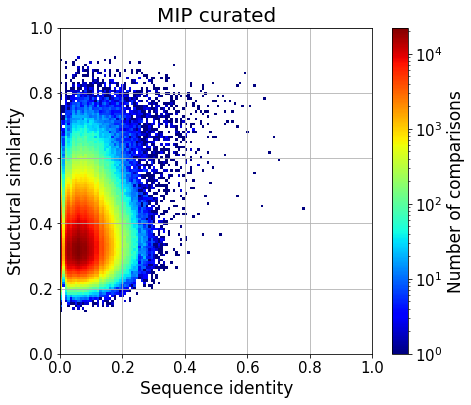

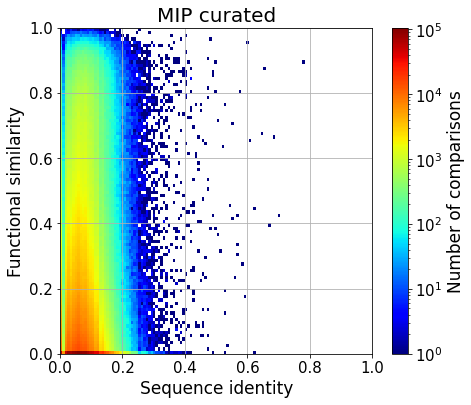

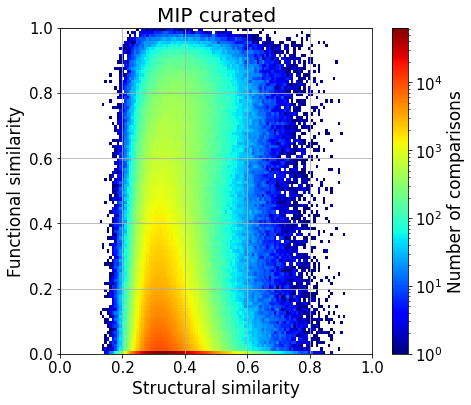

In [15]:
params = [{'cols': ["Sequence identity",  "TM-score max"], 
          'xylabels': ["Sequence identity", "Structural similarity"]},
          {'cols': ["Sequence identity",  "DeepFRI GCN cossim denoised"], 
          'xylabels': ["Sequence identity", "Functional similarity"]},
          {'cols': ["TM-score max", "DeepFRI GCN cossim denoised"], 
          'xylabels': ["Structural similarity", "Functional similarity"]}]

# Generate all plots
dfs = [rosetta_m2m_curated, dmpfold_m2m_curated]
labels = ["Rosetta", "DMPFold"]

# Generate plots in the paper only
dfs = [rosetta_m2m_curated,]
labels = ["Rosetta"]

for par in params:
    plt.figure(figsize = (7*len(dfs), 6))
    for i, df in enumerate(dfs):
        plt.subplot(1, len(dfs), i + 1)
        data = df[par['cols']].values 
        plt.hist2d(data[:, 0], data[:, 1], (100, 100), norm=mpl.colors.LogNorm(), cmap=plt.cm.jet)
        cbar=plt.colorbar()
        cbar.ax.set_ylabel('Number of comparisons', fontsize=17)
        cbar.ax.tick_params(axis='both', which='major', labelsize=15)
        # plt.title(labels[i], fontsize=20)
        plt.title('MIP curated', fontsize=20)
        plt.xlabel(par['xylabels'][0], fontsize=17)
        plt.ylabel(par['xylabels'][1], fontsize=17)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.grid(True)
        par_str_1 = par['xylabels'][0].lower().replace(' ', '-')
        par_str_2 = par['xylabels'][1].lower().replace(' ', '-')
        # Save figure
        plt.savefig(OUT_DIR / f'Figure_2_MIP-curated_{labels[i]}_{par_str_1}_vs_{par_str_2}.png', 
                    bbox_inches = 'tight', dpi=400) 
        # Save data
        df[par['cols'] + ['MIP name 1', 'MIP name 2']].to_csv(
            OUT_DIR / f'Figure_2_MIP-curated_{labels[i]}_{par_str_1}_vs_{par_str_2}.csv',
            header=[par['xylabels'][0], par['xylabels'][1], 'MIP ID 1', 'MIP ID 2'], index=False)
    plt.show()

## Figure S65

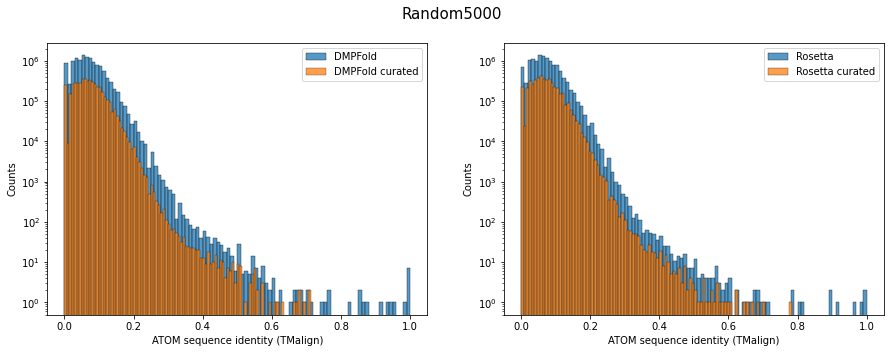

In [15]:
dfs = [dmpfold_m2m, rosetta_m2m]
dfs_curated = [dmpfold_m2m_curated, rosetta_m2m_curated]
labels = ["DMPFold", "Rosetta"]

plt.figure(figsize=(15, 5))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    ax = sns.histplot(dfs[i]['Sequence identity'], label=labels[i],
                 color=sns.color_palette()[0], bins=100)
    sns.histplot(dfs_curated[i]['Sequence identity'], 
                 label=f"{labels[i]} curated", 
                 color=sns.color_palette()[1], bins=100)
    ax.set(xlabel='ATOM sequence identity (TMalign)', 
           ylabel='Counts', yscale='log')
    plt.legend()
    plt.suptitle('Random5000', fontsize=15)
plt.show()